In [1]:
import pandas as pd

heart_file_path = 'cardio_data_processed.csv'
raw_df = pd.read_csv(heart_file_path)
raw_df.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,age_years,bmi,bp_category,bp_category_encoded
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0,50,21.967120,Hypertension Stage 1,Hypertension Stage 1
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1,55,34.927679,Hypertension Stage 2,Hypertension Stage 2
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1,51,23.507805,Hypertension Stage 1,Hypertension Stage 1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1,48,28.710479,Hypertension Stage 2,Hypertension Stage 2
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0,47,23.011177,Normal,Normal


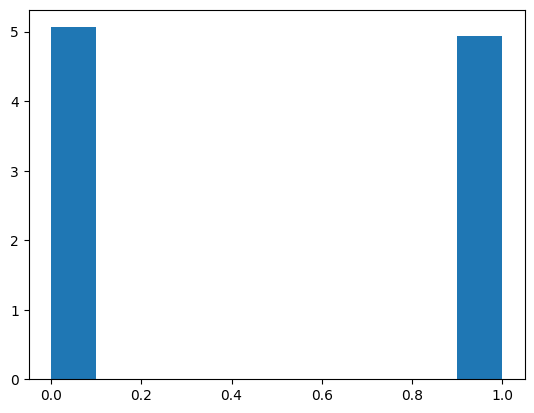

In [2]:
import matplotlib.pyplot as plt

plt.hist(raw_df['cardio'], density=1)
plt.show()
# dataset balanceado

In [3]:
# get target values and corresponding ids
df_targets_with_ids = raw_df[['id', 'cardio']]

# remove ids, bp_category_encoded, age (days version) and targets
# bp_category_encoded was supposed to be bp_category with proper proccessing for ML but it is not, so we can just drop it

df = raw_df.drop(columns=['id', 'age', 'cardio', 'bp_category_encoded'])
df.head()

,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,age_years,bmi,bp_category
0,2,168,62.0,110,80,1,1,0,0,1,50,21.967120,Hypertension Stage 1
1,1,156,85.0,140,90,3,1,0,0,1,55,34.927679,Hypertension Stage 2
2,1,165,64.0,130,70,3,1,0,0,0,51,23.507805,Hypertension Stage 1
3,2,169,82.0,150,100,1,1,0,0,1,48,28.710479,Hypertension Stage 2
4,1,156,56.0,100,60,1,1,0,0,0,47,23.011177,Normal


**Adjust bp_category for model input**

- bp_category: blood pressure category based from ap_hi and ap_lo: "Normal", "Elevated", "Hypertension Stage 1", "Hypertension Stage 2" and  "Hypertensive Crisis"

In [4]:
from sklearn.preprocessing import OrdinalEncoder

ordinal_encoder = OrdinalEncoder()
categorical_variables = df[['gender', 'cholesterol', 'gluc', 'smoke', 'alco', 'active', 'bp_category']]

encoded_categoricals = ordinal_encoder.fit_transform(categorical_variables)
print(encoded_categoricals)

[[1. 0. 0. ... 0. 1. 1.]
 [0. 2. 0. ... 0. 1. 2.]
 [0. 2. 0. ... 0. 0. 1.]
 ...
 [1. 2. 0. ... 1. 0. 2.]
 [0. 0. 1. ... 0. 0. 1.]
 [0. 1. 0. ... 0. 1. 1.]]


In [5]:
from sklearn.preprocessing import MinMaxScaler

# OBS: mimaxscaler fit_transform() deve ser usado  apenas em dados de TREINO! Para dados de teste usamos apenas o transform()
minmaxscaler = MinMaxScaler()
numeric_variables = df[['height', 'weight', 'ap_hi', 'ap_lo', 'age_years', 'bmi']]

encoded_numericals = minmaxscaler.fit_transform(numeric_variables)
print(encoded_numericals)

[[0.57948718 0.26984127 0.22222222 0.33333333 0.6        0.06265466]
 [0.51794872 0.39153439 0.55555556 0.5        0.74285714 0.10655976]
 [0.56410256 0.28042328 0.44444444 0.16666667 0.62857143 0.06787388]
 ...
 [0.65641026 0.4973545  1.         0.5        0.65714286 0.09445216]
 [0.55384615 0.32275132 0.5        0.33333333 0.91428571 0.08004023]
 [0.58974359 0.32275132 0.33333333 0.33333333 0.77142857 0.07263578]]


Sum everything to get preproccessed dataset

In [6]:
df_encoded_num = pd.DataFrame(encoded_numericals, columns=numeric_variables.columns)

df_encoded_cat = pd.DataFrame(encoded_categoricals, columns=categorical_variables.columns)

# Concatenate the two DataFrames side-by-side (axis=1)
df_processed = pd.concat([df_encoded_num, df_encoded_cat], axis=1)

print(df_processed.head())

     height    weight     ap_hi     ap_lo  age_years       bmi  gender  \
0  0.579487  0.269841  0.222222  0.333333   0.600000  0.062655     1.0   
1  0.517949  0.391534  0.555556  0.500000   0.742857  0.106560     0.0   
2  0.564103  0.280423  0.444444  0.166667   0.628571  0.067874     0.0   
3  0.584615  0.375661  0.666667  0.666667   0.542857  0.085498     1.0   
4  0.517949  0.238095  0.111111  0.000000   0.514286  0.066192     0.0   

   cholesterol  gluc  smoke  alco  active  bp_category  
0          0.0   0.0    0.0   0.0     1.0          1.0  
1          2.0   0.0    0.0   0.0     1.0          2.0  
2          2.0   0.0    0.0   0.0     0.0          1.0  
3          0.0   0.0    0.0   0.0     1.0          2.0  
4          0.0   0.0    0.0   0.0     0.0          3.0  


**Create Pipeline for K-fold cross-validation**
1. Pre proccess data

In [7]:
from sklearn.compose import ColumnTransformer

X = raw_df
y = df_targets_with_ids.drop(columns=['id'])

numerical_cols = ['height', 'weight', 'ap_hi', 'ap_lo', 'age_years', 'bmi']
nominal_cols = ['gender', 'cholesterol', 'smoke', 'alco', 'active']
ordinal_cols = ['gluc', 'bp_category']

# Define order for ordinal features
ord_categories = [
    [1, 2, 3],
    ['Normal', "Elevated", "Hypertension Stage 1", "Hypertension Stage 2", "Hypertensive Crisis"]
]

# cleaner way of doing column preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ("num", MinMaxScaler(), numerical_cols),
        ("cat", OrdinalEncoder(handle_unknown="error"), nominal_cols),
        ("ord", OrdinalEncoder(categories=ord_categories), ordinal_cols)
    ]
)

2. Select models for evaluation

In [8]:
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

logistic_regression = LogisticRegression(max_iter=1000)
naive_bayes = GaussianNB()
# metrics: gini, entropy
decision_tree = DecisionTreeClassifier(random_state=42)

models = {
    "naive_bayes": naive_bayes,
    'decision_tree': decision_tree,
    'logistic_regression': logistic_regression
}

3. Evaluate models

In [26]:
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.pipeline import Pipeline

kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

results = {}

for name, classifier in models.items():
    pipe = Pipeline([
        ("preprocessor", preprocessor),
        ("model", classifier)
    ])
    scores = cross_val_score(pipe, X, y, cv=kfold, scoring="accuracy")
    results[name] = scores
    print(f"{name}: {scores.mean():.3f} ± {scores.std():.3f}")

df_results = pd.DataFrame({
    model: [scores.mean(), scores.std()] 
    for model, scores in results.items()
}, index=["mean_accuracy", "std_dev"]).T

print(df_results)

/home/lshoss/anaconda3/envs/heart/lib/python3.14/site-packages/sklearn/utils/validation.py:1406: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/lshoss/anaconda3/envs/heart/lib/python3.14/site-packages/sklearn/utils/validation.py:1406: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/lshoss/anaconda3/envs/heart/lib/python3.14/site-packages/sklearn/utils/validation.py:1406: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/lshoss/anaconda3/envs/heart/lib/python3.14/site-packages/sklearn/utils/validation.py:1406: DataConversionWarning: A column-vector y was 

naive_bayes: 0.715 ± 0.003
decision_tree: 0.635 ± 0.004


/home/lshoss/anaconda3/envs/heart/lib/python3.14/site-packages/sklearn/utils/validation.py:1406: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/lshoss/anaconda3/envs/heart/lib/python3.14/site-packages/sklearn/utils/validation.py:1406: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/lshoss/anaconda3/envs/heart/lib/python3.14/site-packages/sklearn/utils/validation.py:1406: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/lshoss/anaconda3/envs/heart/lib/python3.14/site-packages/sklearn/utils/validation.py:1406: DataConversionWarning: A column-vector y was 

logistic_regression: 0.726 ± 0.002
                     mean_accuracy   std_dev
naive_bayes               0.714537  0.003299
decision_tree             0.635115  0.004433
logistic_regression       0.726398  0.001773


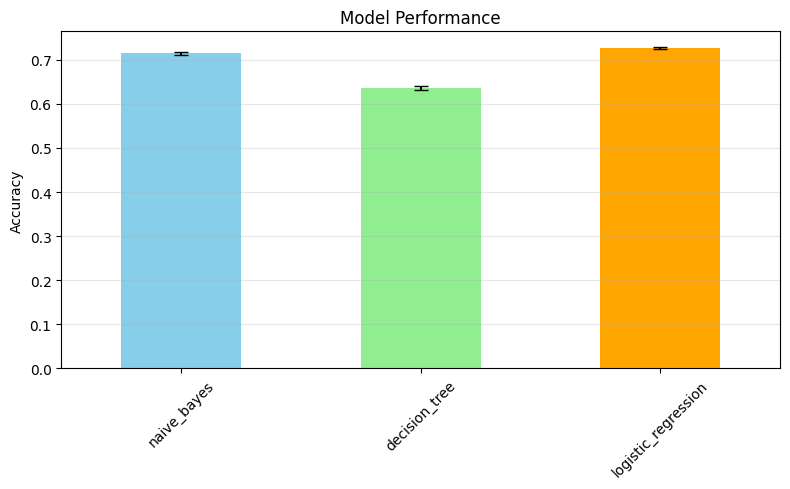

In [27]:
plt.figure(figsize=(8, 5))
df_results['mean_accuracy'].plot(kind='bar', yerr=df_results['std_dev'], 
                                capsize=5, color=['skyblue', 'lightgreen', 'orange'])
plt.title('Model Performance')
plt.ylabel('Accuracy')
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

Index(['model', 'model', 'model', 'model', 'mean_accuracy', 'std_dev'], dtype='object')